# I. Introduction to MCMC via Metropolis-Hastings

Before reading any further, do you have a basic understanding of Bayesian statistics? If yes, read on. If not, check out this article before proceeding (https://towardsdatascience.com/bayesian-stats-101-for-data-scientists-a8c145a84259). It covers everything you need to know before learning about Markov Chain Monte Carlo (MCMC).

Now that bit of business is out of the way, what is the point of MCMC algorithms? Bayesian statistics is all about deriving posterior distributions for a parameter of interest based on prior beliefs and your data. Sometimes this can be done analytically. Often it can't and requires numerical methods to simulate the posterior distribution. That's what MCMC algorithms do.

A good introduction to MCMC sampling is the Metropolis-Hastings Algorithm. There are 5 steps. Lets first define some parameters and functions.

$\underset{\sim}{\theta}$: the random parameter for which we are simulationting the distribution

$Y$: the random variable that depends on $\underset{\sim}{\theta}$

$y$: realizations of the random variable $Y$ (our sample)

$f_{\underset{\sim}{\theta}}(\theta)$: our prior (updated each step with the value from the previous period)

$f_{Y|\underset{\sim}{\theta}}(y|\theta)$: our likelihood

$f_{\underset{\sim}{\theta}|Y}(\theta|y)$: our posterior $\propto f_{\underset{\sim}{\theta}}(\theta) * f_{Y|\underset{\sim}{\theta}}(y|\theta)$

$J_{\underset{\sim}{\theta}}(\theta|\theta_{t-1})$: our jumping distribution, used to generate proposed new values of $\theta$

Now that we have defined our parameters, variables, and functions, we can proceed through the 5 steps for the Metropolis-Hastings algorithm.


## Step 1

Choose a starting value: $\theta_{t-1}$. At $t=1$, $\theta_{t-1}$ is our starting prior value for $\theta$.

## Step 2

Generate a propoal for period $t$, $\theta^{*}_{t}$ by sampling from the jumping distribution $J(\theta|\theta_{t-1})$. The Monte Carlo in MCMC comes from the fact that we are simulating a random number from our jumper distribution. The Markov Chain in MCMC comes from the fact our $\theta^{*}_{t}$ is only dependent on the value of $\theta_{t-1}$. The process is "memory-less" and thus a Markov Chain.

## Step 3

Find the ratio of the posterior of the proposal to the posterior of the prior value: 
## $r = \frac{\frac{f_{\underset{\sim}{\theta}|Y}(\theta^{*}_{t}|y)}{J_{\underset{\sim}{\theta}}(\theta^{*}_{t}|\theta_{t-1})}}{\frac{f_{\underset{\sim}{\theta}|Y}(\theta_{t-1}|y)}{J_{\underset{\sim}{\theta}}(\theta_{t-1}|\theta^{*}_{t})}}$

For symmetric jumping distributions, $J_{\underset{\sim}{\theta}}(\theta^{*}_{t}|\theta_{t-1}) = J_{\underset{\sim}{\theta}}(\theta_{t-1}|\theta^{*}_{t})$, so $r = \frac{f_{\underset{\sim}{\theta}}(\theta^{*}_{t})f_{Y|\underset{\sim}{\theta}}(y|\theta^{*}_{t})}{f_{\underset{\sim}{\theta}}(\theta_{t-1})f_{Y|\underset{\sim}{\theta}}(y|\theta_{t-1})}$.

## Step 4

Generate a random number: $a\sim Uniform(0,1)$. 

If $r > a$, $\theta_t = \theta^*_t$ (we accept the proposed value). This has probability $min(r, 1)$.

If  $r \leq a$, $\theta_t = \theta_{t-1}$ (we reject the proposed value and use the prior value). This has probability $1 - min(r, 1)$.

If $r \geq 1$ ($\theta^{*}_{t}$ is more likely than $\theta_{t-1}$), it will always be accepeted. We sometimes accept $\theta^*_t$ because we do not want to be trapped at a local minimum.

## Step 5

Repeat until we reach the number of max number of iterations.

It is common to "burn" a portion of the simated posterior distribution of $\underset{\sim}{\theta}$ because it can take many iterations for the algorithm to search the parameter space for likely values. After removing the "burn-in" we have the simulated posterior that we can use for Bayesian inference, such as constructing credible intervals.

# II. MCMC for Logistic Regression

Now that we understand Metropolis-Hastings, we can modify it to fit the coefficients in a logisitc regression model. The parameters being estimated are $\beta_j$'s for $j=1,2,...k$, where $k$ is the number of coefficients in the model. The main difference is there will be multiple parameters to estimate instead of one. I handled this by generating proposals for each $\beta_j$ every round, but randomizing the order of the $\beta_j$'s every round.

To build our MCMC algorithm to fit a logistic regression model, we need to define 4 functions. These will allow us to calculate the ratio our posterior for proposed $\beta_j$ at each step in the MCMC algorithm. The first will also help us to predict probabilities from our model.

1. The first is **inv_logit**, which undoes a logit transformation. A logit transformation translates a probability to log-odds ( $ln(\frac{p}{1-p})$, where $p$ is the probability). The output from logistic regression is in log-odds format. We need this function to translate the predicted log-odds to probabilites when calculating the log-likelihood of our $\beta$ vector given our data. Our vector of predicted probabilities is $p = \frac{e^{X\beta}}{1+e^{X\beta}}$.

2. The second is **normal_log_prior**, which calculates the log of the prior of our $\beta$ vector given our prior beliefs about the means and standard deviations of the individual $\beta_j$'s, assuming our $\beta_j$'s are normally distributed. It is the natural log of the density of the random vector $N\sim ($***prior mean***$_j,$ ***prior std. dev.***$_j)$ at $\beta$.

3. The third is **log_likelihood**, which calculates the log of the likelihood of our $\beta$ vector given the data. As we are modeling a 2 class problem with our logistic regression, a single observation has a  Bernoulli probability mass function (*PMF*) $P(Y_i = y_i | X_i = x_i) = p_i^{y_i} * (1 - p_i)^{1 - y_i}$. The likelihood of our $\beta$ vector given the data is the product of the individual *PMF*s: $L(\beta) = \prod^{n}_{i=1}\hat{p}_i^{y_i} * (1 - \hat{p}_i)^{1 - y_i}$. The log-likelihood is thus: $l(\beta) = \sum^{n}_{i=1}ln(\hat{p}_i^{y_i}) + ln((1 - \hat{p}_i)^{1 - y_i}) = \sum^{n}_{i=1}y_i*ln(\hat{p}_i) + (1 - y_i)*ln((1 - \hat{p}_i))$

4. Finally, **log_posterior** calculates the posterior probability of $\beta$ vector given the data and our prior beliefs. $posterior \propto prior * likelihood$, so $ln(posterior) \propto ln(prior) + ln(likelihood)$.

With those defined, I was able to implement a modified Metropolis-Hastings. I also added functions to remove the "burn-in", calculate credible intervals, and make predictions. To make predictions, the user needs to specify whether they want to use either the median, mean, or mode of the simulated posteriors of each $\beta_j$ as the coefficients in the vector $\hat{\beta}$.

In [1]:
class mcmc_logistic_reg:
    
    import numpy as np
    
    def __init__self(self):
        self.raw_beta_distr = np.empty(1)
        self.beta_distr = np.empty(1)
        self.beta_hat = np.empty(1)
        self.cred_ints = np.empty(1)
    
    def inv_logit(self, beta, X):
        ###
        # A function to undo a logit transformation. Translates log-odds to 
        # probabilities.
        ###
        return (np.exp(np.matmul(X, beta.reshape((-1, 1)))) / 
                (1 + np.exp(np.matmul(X, beta.reshape((-1, 1))))))
    
    def normal_log_prior(self, beta, prior_means, prior_stds):
        ###
        # A function to calculate the log prior using a normal prior. The
        # log prior is used to avoid underflow.
        ###
        from scipy.stats import norm
        import numpy as np
        
        return np.sum(norm.logpdf(beta, loc=prior_means.reshape((-1, 1)), 
                                  scale=prior_stds.reshape((-1, 1)))) 
    
    def log_likelihood(self, y, X, beta):
        ###
        # Defines a function to calculate the log likelihood of the betas given 
        # the data. Uses the log likelihood instead of the normal likelihood to 
        # avoid underflow.
        ###        
        return np.sum(y * np.log(self.inv_logit(beta.reshape((-1, 1)), X)) + 
                      (1-y)*np.log((1-self.inv_logit(beta.reshape((-1,1)),X))))
    
    def log_posterior(self, y, X, beta, prior_means, prior_sds):
        ###
        # Defines a function to calculate the log posterior of the betas given 
        # the log likelihood and the log prior assuming it is a normal prior.
        ###      
        return (self.normal_log_prior(beta, prior_means, prior_stds) + 
                self.log_likelihood(y, X, beta))
    
    def mcmc_solver(self, 
                               y, 
                               X, 
                               beta_priors, 
                               prior_stds,
                               jumper_stds, 
                               num_iter,
                               add_intercept,
                               random_seed):
        
        from scipy.stats import norm
        from tqdm import tqdm
        
        # set a random seed
        np.random.seed(random_seed)
        
        # add an intercept if desired
        if add_intercept:
            X_mod = np.append(np.ones(shape=(X.shape[0], 1)),X, 1)
        else:
            X_mod = X
            
        # creates a list of beta indexes to be looped through each iteration
        beta_indexes = [k for k in range(len(beta_priors))]
        
        ###
        # Initialize beta_hat with the priors. It will be have a number of rows
        # equal to the number of beta coefficients and a number of columns
        # equal to the number of iterations + 1 for the prior. Each row will 
        # hold values of a single coefficient. Each column is an iteration
        # of the algorithm.
        ###
        beta_hat = np.array(np.repeat(beta_priors, num_iter+1))
        beta_hat = beta_hat.reshape((beta_priors.shape[0], num_iter+1))
        
        # perform num_iter iterations
        for i in tqdm(range(1, num_iter + 1)):
            
            # shuffle the beta indexes so the order of the coefficients taking 
            # the Metropolis step is random
            np.random.shuffle(beta_indexes)
            
            # perform the sampling for each beta hat sequentially
            for j in beta_indexes:
                
                # generate a proposal beta using a normal distribution and the 
                # beta_j
                proposal_beta_j = beta_hat[j, i-1] + norm.rvs(loc=0, 
                                                              scale=jumper_stds[j], 
                                                              size=1)
                
                # get a single vector for all the most recent betas
                beta_now = beta_hat[:, i-1].reshape((-1, 1))
                
                # copy the current beta vector and insert the proposal beta_j 
                # at the jth index
                beta_prop = np.copy(beta_now)
                beta_prop[j, 0] = proposal_beta_j
                
                # calculate the posterior probability of the proposed beta
                log_p_proposal = self.log_posterior(y, X_mod, beta_prop, 
                                                    beta_now, prior_stds)
                # calculate the posterior probability of the current beta
                log_p_previous = self.log_posterior(y, X_mod, beta_now, 
                                                    beta_now, prior_stds)
                
                # calculate the log of the r-ratio
                log_r = log_p_proposal - log_p_previous
                
                # if r is greater than a random number from a Uniform(0, 1) 
                # distribution add the proposed beta_j to the list of beta_js
                if np.log(np.random.random()) < log_r:
                    beta_hat[j, i] = proposal_beta_j
                # otherwise, just add the old value
                else:
                    beta_hat[j, i] = beta_hat[j, i-1]
        
        # sets the attribute raw_beta_distr to matrix of beta_hat
        self.raw_beta_distr = beta_hat
    
    def trim(self, burn_in):
        ###
        # This function that trims the distribution of beta hats based on the 
        # burn-in rate
        ###
        start = 1 + round(burn_in * self.raw_beta_distr.shape[1] - 1)
        
        # sets the attribute beta_distr to the raw_beta_distr minus the burn-in
        self.beta_distr = self.raw_beta_distr[:, start:-1]
        
    def credible_int(self, alpha=0.05):
        ###
        # Returns the 100*(1-alpha)% credible interval for each coefficient in
        # a 2 by number of coefficients numpy array
        ###
        from numpy import transpose, quantile
        self.cred_ints =  transpose(quantile(self.beta_distr,
                                             q=(alpha/2, 1-alpha/2),
                                             axis=1))
    
    def fit(self, method = 'median'):
        ###
        # Uses the distribution of betas_hat without the burn-in to either give
        # the median, mean, or mode as an estimate of the beta vector
        ###
        
        from numpy import median, mean
        from scipy.stats import mode
        
        if method == 'median':
            beta_hat = median(self.beta_distr, axis=1).reshape((-1,1))
        elif method == 'mean':
            beta_hat = mean(self.beta_distr, axis=1).reshape((-1,1))
        else:
            beta_hat = mode(self.beta_distr, axis=1)[0]
        
        # sets the beta_hat attribute to either the median, mean, or mode
        self.beta_hat = beta_hat
        
    def predict(self, X_new, add_intercept=True, prob=True):
        ###
        # Gives predictions, either in log-odds or probabilities (default)
        ###
        from numpy import matmul
        
        # add an intercept column if desired
        if add_intercept:
            X_mod = np.append(np.ones(shape=(X_new.shape[0], 1)),X_new, 1)
        else:
            X_mod = X_new
        
        # outputs predicted probabilities if prob == True
        if prob:
            predictions = self.inv_logit(self.beta_hat, X_mod)
        # outputs predicted log-odds otherwise
        else:
            predictions = matmul(X_mod, self.beta_hat)
            
        # returns predictions
        return predictions
    
    def predict_class(self, X_new, add_intercept=True, boundary=0.5):
        ###
        # predicts the class of the new observations based on a decision 
        # boundary for probability. If predicted probability > boundary, it
        # belongs to class 1
        ###
        from numpy import where
        # predict the probabilities
        preds = self.predict(X_new, add_intercept, prob=True)
        # set predictions to 1 or 0 based on boundary
        pred_classes = where(preds > boundary, 1, 0)
        
        return pred_classes

# III. Trying out the MCMC Model on Real Data

The data set I used contained 86 candies (https://www.kaggle.com/fivethirtyeight/the-ultimate-halloween-candy-power-ranking/). I chose a simple model using "pricepercent" ("The unit price percentile compared to the rest of the set.") to predict the probability a candy is chocolate.

The model being fit is:

$ln(\frac{P(Y=chocolate|X)}{1 - P(Y=chocolate|X)}) = \beta_0 + \beta_1*PricePercentile$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load in field goal data
all_data = pd.read_csv('candy-data.csv')

# list of independent variables in the model
vars_of_interest = ['pricepercent']
# name of dependent variable
target = 'chocolate'

my_data = all_data[[target] + vars_of_interest]
my_data = all_data.dropna()

# make a column vector numpy array for the dependent variable
y = np.array(my_data[target]).reshape((-1,1))
# make a column vector numpy array for the independent variable
X = np.array(my_data[vars_of_interest]).reshape((-1,len(vars_of_interest)))

# make a numpy array for the beta means priors
beta_priors = np.repeat(0.0, len(vars_of_interest)+1) 
# make a numpy array for the beta standard deviation priors
prior_stds = np.repeat(1, len(vars_of_interest))
# make a row vector numpy array for the standard deviation of the jumper distribution
jumper_stds = np.repeat(0.1, len(vars_of_interest)+1) 

# set the number of iterations to run
num_iter = 50000
# set what early portion to burn out
burn_in = 0.1
# set an alpha for the credible interval
cred_int_alpha = 0.05
# set to true to add an intercept to the data
add_intercept = True
# set the random seed
random_seed = 1

# set the decision boundary for classes
boundary = 0.5

# create an instance of the mcmc_logistic_reg
mcmc_log_mod = mcmc_logistic_reg()
# create the untrimmed distribution of beta hats
mcmc_log_mod.mcmc_solver(y, 
                         X,
                         beta_priors, 
                         prior_stds,
                         jumper_stds, 
                         num_iter,
                         add_intercept,
                         random_seed)
# create a distribution of beta_hats without the burn-in
mcmc_log_mod.trim(burn_in)
# use the median of the beta hats distributions as the coefficients for prediction
mcmc_log_mod.fit(method='median')
# create credible intervals for the 
mcmc_log_mod.credible_int(cred_int_alpha)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:43<00:00, 1143.92it/s]


As you can see, the simulated joint distribution of the $\beta_0$ and $\beta_1$ is forming an elliptical region (as the joint distributions in generalized linear models do). In the joint distribution plot containing the burn-in rounds, the coefficients "walk" from the origin, go around in a circle for a bit, and then reach an elliptical region. This is the coefficients walking from the priors to the region we can consider our "true" simulated joint distribution. The 95% credible interval for $\beta_0$ is [-3.67, -1.32] and for $\beta_1$ is [2.50, 6.72]. The simulated median value of $\beta_0$ is -2.44 and the simulated median value of $\beta_1$ is 4.48. Being more expensive has a positive impact of the probability a candy is chocolate.

Looking at the plot of Price Percentile vs. Probability of Being Chocolate we can see our model has a nice S-curve shape shown in textbooks for logistic regression. It doesn't appear to do a great job in classifying candy as chocolate (a lot of false negatives compared to true positives) so a more complex model is probably needed.*

*Of course you should use validation and testing data sets to evaluate a model's performance when building a real predictive model. The train, validate, test process is not the subject of this article. Applying MCMC is the subject.

Now that we've fit a logistic regression with the modified Metropolis-Hastings algorithm, let's compare the results to standard Maximum Likelihood Estimation estimation.

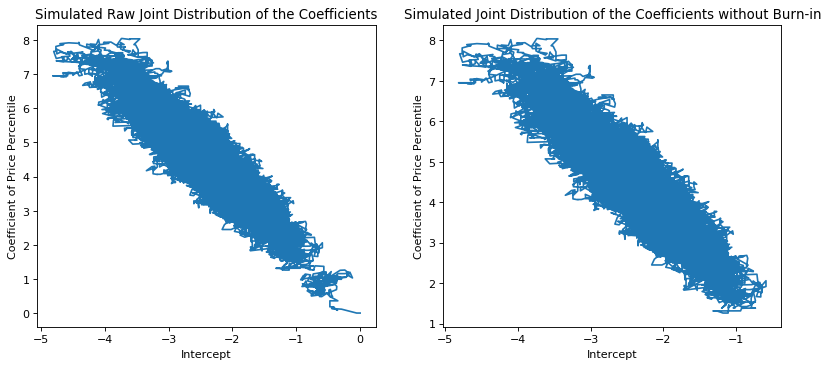

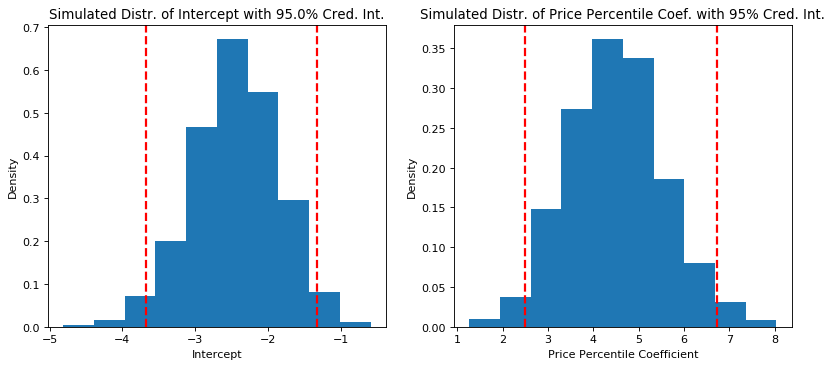

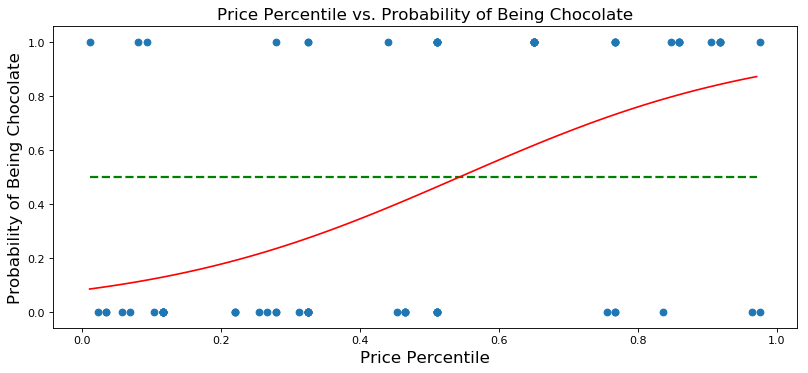

In [3]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(mcmc_log_mod.raw_beta_distr[0], mcmc_log_mod.raw_beta_distr[1])
plt.title('Simulated Raw Joint Distribution of the Coefficients', fontsize=12)
plt.xlabel('Intercept', fontsize=10)
plt.ylabel('Coefficient of Price Percentile', fontsize=10)

plt.subplot(1, 2, 2)
plt.plot(mcmc_log_mod.beta_distr[0], mcmc_log_mod.beta_distr[1])
plt.title('Simulated Joint Distribution of the Coefficients without Burn-in', fontsize=12)
plt.xlabel('Intercept', fontsize=10)
plt.ylabel('Coefficient of Price Percentile', fontsize=10)
plt.show();


plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.hist(mcmc_log_mod.beta_distr[0], density=True)
plt.title(f'Simulated Distr. of Intercept with {100 * (1-cred_int_alpha)}% Cred. Int.', 
          fontsize=12)
plt.xlabel('Intercept', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.axvline(x=mcmc_log_mod.cred_ints[0,0], color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=mcmc_log_mod.cred_ints[0,1], color='r', linestyle='dashed', linewidth=2)

plt.subplot(1, 2, 2)
plt.hist(mcmc_log_mod.beta_distr[1], density=True)
plt.title(f'Simulated Distr. of Price Percentile Coef. with {int(100 * (1-cred_int_alpha))}% Cred. Int.', 
          fontsize=12)
plt.xlabel('Price Percentile Coefficient', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.axvline(x=mcmc_log_mod.cred_ints[1,0], color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=mcmc_log_mod.cred_ints[1,1], color='r', linestyle='dashed', linewidth=2)
plt.show();

# to make the regression line
x_ = np.arange(my_data[vars_of_interest[0]].min(), 
              my_data[vars_of_interest[0]].max(), 
              step=0.01)
x_ = x_.reshape((-1, 1))
y_ = mcmc_log_mod.predict(x_)

plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(x_, y_, '-', color='r')
plt.scatter(X, y)
plt.hlines(xmin=x_[0], xmax=x_[-1], y=boundary, color='g', linestyle='dashed', linewidth=2)
plt.title('Price Percentile vs. Probability of Being Chocolate', fontsize=15)
plt.xlabel('Price Percentile', fontsize=15)
plt.ylabel('Probability of Being Chocolate', fontsize=15)
plt.show;

Recall the 95% credible interval for $\beta_0$ is [-3.67, -1.32] and for $\beta_1$ is [2.50, 6.72]. The simulated median values are -2.44 and 4.48, respectfully.

In the model using MLE estimation, $\hat{\beta}_0$ is 2.36, which is very close to the median of the simulated posterior of the intercept in the MCMC model. The 95% confidence interval is [-3.47, -1.24], which is close the 95% credible interval in the MCMC model. $\hat{\beta}_1$ is 4.31 and the 95% confidence interval is [2.30, 6.32]. This is again close to the results from the MCMC model. They mostly agree!

In [4]:
from statsmodels.discrete.discrete_model import Logit

# add an intercept since statsmodels does not
my_data['Intercept'] = 1

# fit the logistic regression model using MLE
mle_mod = Logit(my_data[target], my_data[['Intercept'] + vars_of_interest])
mle_mod_fit = mle_mod.fit(disp=False)

# print the summary
print(mle_mod_fit.summary())

                           Logit Regression Results                           
Dep. Variable:              chocolate   No. Observations:                   85
Model:                          Logit   Df Residuals:                       83
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 May 2020   Pseudo R-squ.:                  0.2026
Time:                        01:01:11   Log-Likelihood:                -46.409
converged:                       True   LL-Null:                       -58.204
                                        LLR p-value:                 1.193e-06
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.3558      0.570     -4.134      0.000      -3.473      -1.239
pricepercent     4.3104      1.024      4.209      0.000       2.303       6.318


If I've done my job right, you know understand the idea behind MCMC, Metropolis-Hastings in particular, and understand how they can be applied to practical problems such as fitting a logistic regression model. Thanks for reading!